FINAL REPORT

Adequate comments 6 pts Your code contains code comments that are helpful to the reader in understanding what your blocks/lines of code are doing.

 Notebook contains adequate markdown that documents your thought process, navigating through the pipeline. This helps your reader not get lost in the details.

 Includes summary 2 pts Your conclusion summary addresses the questions you raised in the opening of the project, which we would want to see at the end of every report notebook. Ideally, when the deliverable is a report such as this, the summary should tie together your analysis, the drivers of the outcome, and how you would expect your ML model to perform in the future on unseen data, in layman's terms.

Includes recommendations 2 pts In addition to your summary, you included actionable recommendations based on your insights and analysis to your simulated audience, or someone who would find this information valuable. Your recommendations were not about what to do differently with the data, but instead are based on the business or domain you are studying. Nice work.

 includes next steps 2 pts Your conclusion includes next steps from a data science perspective that will assist in improving your research. Ideally, if you talk about trying more algorithms to improve performance, think about why you need to improve performance. And if the business calls for it, remember the best way to improve performance is to have better predictors/features. If you talk about gathering more data, being specific about what data you think will help you understand the problem better and why is the way to go!

 No Errors 5 pts Your final notebook runs without error.


PRESENT

Timely and planned 2 pts

 Great Intro 2 pts You kicked off your presentation by introducing yourself and a one-liner of what your project is about.

Notebook matched presentation 2 pts Notebook was clean and relevant such that what was talked about what easy to see in the notebook, and what was in the notebook was relevant information that was included in the presentation.

Considered audience/setting 2 pts You clearly considered the audience and setting in which the presenation was delivered. The language was professional, volume and speed of talk was appropriate, as was level of depth, and it was easy to follow you throughout the presentation.

Conclusion with summary 2 pts Your presentation concluded with a summary of what was found, recommendations, and next steps.










# Zillow Zestimate and Log Error

## Goals:

- Investigate drivers of Log Error in Single Family Properties that had a transaction in 2017.

- Construct a ML regression model that accurately predicts property Log Error.

# Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt

import wrangle as w
import explore as e
#import modeling as m

import env
from scipy import stats

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer, PolynomialFeatures

import warnings
warnings.filterwarnings("ignore")

# Acquire

- Data acquired from zillow database


- It contained 52,441 rows and 7 columns before cleaning


- Each row represents a Single Family Property that had a transaction in 2017


- Each column represents a feature that describes the Single Property Home

In [2]:
# Acquiring data and clean-up
df = w.wrangle_zillow()

# Prepare

- Check for nulls (nulls were found and removed)


- Renamed columns for readability


- Split data into train, validate, and test sets


- Properties with 7 or more bathrooms and bedrooms were considered outliers and removed.

- Properties with 0 bathrooms and bedrooms were considered outliers and removed.


- Properties with a square footage greater than 10,000 ft^2 were considered outliers and removed.

- Properties with a tax rate less than 10 were considered outliers and removed.

- We are left with 50677 rows, 97% of data remains after cleaning

In [3]:
train, validate, test = w.split_data(df)

In [4]:
train_scaled, validate_scaled, test_scaled = w.scale_data(train, validate, test)

In [5]:
X_train_scaled = train_scaled[['bedrooms','bathrooms', 'sq_feet']]

# Data Dictionary

| Feature | Definition |
| :- | :- |
| bedrooms | Decimal, # of bedrooms in a property |
| bathrooms | Decimal, # of bathrooms in a property, including fractional bathrooms |
| sq_feet | Decimal, calculated total living area in a property |
| logerror | Decimal, a logarithmic value of the error in model predictions of tax value, our target variable |

# Explore

## Questions:

- Are the number of bedrooms related to log error?


- Are the number of bathrooms related to log error?


- Is square footage related to log error?


- Is the magnitude of log error of observations in cluster 3 significantly different than the mean of the magnitude of log error in train?

In [6]:
X_train, X_train_scaled = e.get_train_clusters()

In [17]:
X_train.head(1)

,bedrooms,bathrooms,sq_feet,is_cluster_3_k7
40409,3.0,3.5,2820.0,1


In [16]:
X_train_scaled.head(1)

,bedrooms,bathrooms,sq_feet,is_cluster_3_k7
40409,0.333333,0.416667,0.275165,1


# Are the number of bedrooms related to log error?

#### I will use a correlation test to determine if 'bedrooms' and 'logerror' are related.

- I will use a confidence interval of 95% with alpha set to .05

#### Ho: 'bedrooms' and 'logerror' are independent of each other.

#### Ha: 'bedrooms' and 'logerror' are related.

In [8]:
e.get_bed_log_corr()

corr  = 0.0288
p     = 0.0000


### The p-value is lower than our alpha, giving us the evidence to support that a relationship exists between 'bedrooms' and 'logerror'. With our null hypothesis rejected, and despite a lack of linear correlation observed in the train data, I believe that using 'bedrooms' in modeling will likely have a significant positive impact on the model's accuracy.

# Are the number of bathrooms related to log error?

#### I will use a correlation test to determine if 'bathrooms' and 'logerror' are related.

- I will use a confidence interval of 95% with alpha set to .05

#### Ho: 'bathrooms' and 'logerror' are independent of each other.

#### Ha: 'bathrooms' and 'logerror' are related.

In [9]:
e.get_bath_log_corr()

corr  = 0.0288
p     = 0.0000


### The p-value is lower than our alpha, giving us the evidence to support that a relationship exists between 'bathrooms' and 'logerror'. With our null hypothesis rejected, and despite a lack of linear correlation observed in the train data, I believe that using 'bedrooms' in modeling will likely have a significant positive impact on the model's accuracy.

# Is square footage related to log error?

#### I will use a correlation test to determine if 'sq_feet' and 'logerror' are related.

- I will use a confidence interval of 95% with alpha set to .05

#### Ho: 'sq_feet' and 'logerror' are independent of each other.

#### Ha: 'sq_feet' and 'logerror' are related.

In [10]:
e.get_bath_log_corr()

corr  = 0.0288
p     = 0.0000


### The p-value is lower than our alpha, giving us the evidence to support that a relationship exists between 'sq_feet' and 'logerror'. With our null hypothesis rejected, and despite a lack of linear correlation observed in the train data, I believe that using 'bedrooms' in modeling will likely have a significant positive impact on the model's accuracy.

## Selecting optimal k clusters

In [18]:
cluster_vars = ['bedrooms','bathrooms', 'sq_feet']
cluster_name = 'interior_cluster_k7'
k_range = range(2,20)

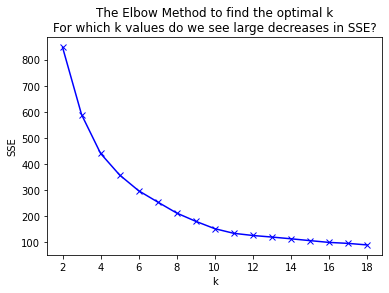

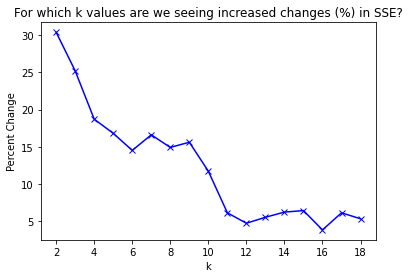

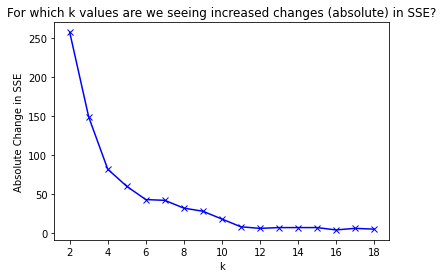

,k,sse,delta,pct_delta
0,2,847.181747,258.0,30.4
1,3,589.352862,149.0,25.2
2,4,440.681249,82.0,18.7
3,5,358.210210,60.0,16.8
4,6,297.973092,43.0,14.5
5,7,254.834492,42.0,16.6
6,8,212.558582,32.0,14.9
7,9,180.991151,28.0,15.6
8,10,152.764988,18.0,11.7
9,11,134.963453,8.0,6.1


In [15]:
e.find_k(X_train_scaled, cluster_vars, k_range)

### We explored through 3 unique cluster models that used the same features from one another with the number of clusters k changing to 5, 6, then 7. Cluster models with k = 5 and k = 6 did not yield groupings that had a significant relationship with 'logerror'.


### Cluster model with k = 7 yielded a grouping labeled '3' with a significant relationship with 'logerror' that we explore below.

# Is the magnitude of log error of observations in cluster 3 significantly different than the mean of the magnitude of log error in train?

#### I will use a correlation test to determine if 'logerror' of observations in cluster 3 and the mean of 'logerror' in train are related.

- I will use a confidence interval of 95% with alpha set to .05

#### Ho: 'logerror' of observations in cluster 3 and the mean of 'logerror' in train are independent of each other.

#### Ha: 'logerror' of observations in cluster 3 and the mean of 'logerror' in train are related.

In [12]:
e.get_cluster_3_ttest(X_train_scaled)

t     = -2.1198
p     = 0.0341


### The p-value is lower than our alpha, giving us the evidence to support that a relationship exists between 'logerror' of observations in cluster 3 and the mean of 'logerror' in train. With our null hypothesis rejected, I believe that using cluster 3 in modeling will likely have a significant positive impact on the model's accuracy.

# Exploration Summary

- 'bedrooms' was found to be a driver of 'logerror'


- 'bathrooms' was found to be a driver of 'logerror'


- 'sq_feet' was found to be a driver of 'logerror'


- Observations in cluster 3 was found to be a driver of 'logerror'

# Modeling
### * Used RMSE as the evalaution metric for our baseline.
### * Models used to evaluated on train and validate data frames:
        * OLS
        * Polynomial 
        * 
        
### * Model that performs best will be used with test data frame.

# Baseline

# OSL

# Polynomial

# Lasso Lars

# Tweedie

# Comparing Models
### * All models performed better than baseline on train and validate.
### * Polynomial Regression yielded the lowest RMSE of all models and will move on to test set.

# Calculating R^2 Coefficient for Variance

### * Our feature chosen explain roughly % of the variance in the log error

# Modeling Summary


# Conclusions

### Exploration


- We initially thought bedrooms, bathrooms, sq_feet, and cluster 3 of cluster model k = 7 would be significant drivers of 'logerror' in our data.


- Selected features did not yield desired outcomes as the selected featured moved down the pipeline into modeling.



### Modeling




# Recommendations


- We should reconsider how we are approaching this problem and further explore our data for feature selection that will yield more substantial results.

# Next Steps

- Explore our data with a new approach.



- Possibly focus more on the location of properties while keeping property size in consideration.